<a href="https://colab.research.google.com/github/Ebrarkaraa/Blockchain-Hackathon/blob/main/WebCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Google Colab ortamında YOLOv4 ile Webcam üzerinden Nesne Tanıma 

In [21]:
# import edilecek bağımlılıklar
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Yolov4 Darknet Kurulumu 
YOLOv4 algılamalarını gerçekleştirmek için bu eğitimde AlexeyAB'nin darknet deposunu kullandım.

In [22]:
# darknet deposunu clonladım.
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [23]:
# makefile'ı GPU, OPENCV ve LIBSO'nun etkin olması için değiştirdim. (LIBSO darknet içinde Python kullanmamızı sağlar.)
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [24]:
#darknet'i oluşturur, böylece darknet.py dosyasını kullanabilir ve bağımlılıklarına sahip olabiliriz.
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [25]:
# paylaşılan google sürücüsünden 80 sınıfı (nesneyi) algılamak için önceden eğitilmiş, ölçeklenmiş yolov4 ağırlık dosyasını aldım.
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-05-25 13:59:13--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.113, 74.125.195.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/teitqubnb1lnie9niaivpa3qfdgrsa9i/1653487125000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2022-05-25 13:59:13--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/teitqubnb1lnie9niaivpa3qfdgrsa9i/1653487125000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-14-84-docs.googleusercontent.com (doc-14-84-

## Darknet for Python

YOLOv4'ü Python koduyla kullanmak için, işlevleri projeye aktararak darknet.py içinde bulunan önceden oluşturulmuş işlevlerden bazılarını kullanalım.

In [26]:
# import darknet functions to perform object detections
from darknet import *
# YOLOv4 mimari ağımıza yükleyin
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# görüntüde algılamayı çalıştırmak için darknet yardımcı işlevi
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # sınırlayıcı kutuları uygun boyuta dönüştürmek için görüntü oranlarını alın
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # algılamaları almak için modeli darknet stili görüntüde çalıştırın
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Test resmi üzerinde örnek deneme 

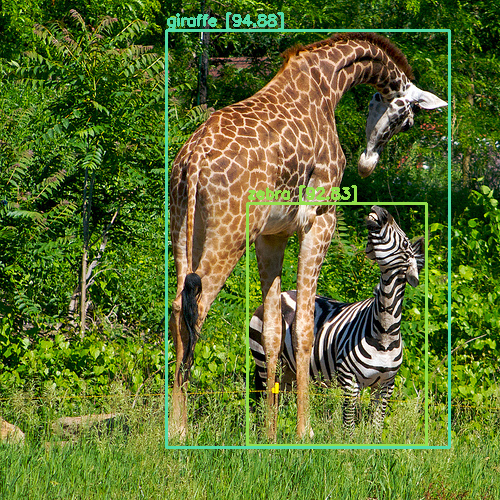

In [27]:
# depoyla birlikte gelen person.jpg görüntüsü üzerinde testi çalıştır
image = cv2.imread("data/giraffe.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Yardımcı Fonksiyonlar 
Aşağıda, sonraki adımlarımızda farklı görüntü türleri arasında kolayca dönüştürme yapmak için kullanılacak tanımlanmış birkaç yardımcı işlev verilmiştir.

In [28]:
# JavaScript nesnesini bir OpenCV görüntüsüne dönüştürme işlevi
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# OpenCV Rectangle bounding box  görüntüsünü video akışına yerleştirilecek base64 bayt dizisine dönüştürme işlevi
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

## Webcam den alınan anlık görüntüden YOLOv4 ile nesne tanıma
YOLOv4'ü web kamerasından alınan görüntüler üzerinde çalıştırmak oldukça basittir. Google Colab'ın çeşitli görevleri gerçekleştirmek için çeşitli yararlı kod işlevlerine sahip **Kod Parçacıkları** içindeki kodu kullanacağız.

Bilgisayarınızın web kamerasını kullanmak için JavaScript kodunu çalıştıran **Camera Capture** için kod parçacığını kullanacağız. Kod parçacığı bir web kamerası fotoğrafı çekecek ve daha sonra nesne algılama için YOLOv4 modelimize geçeceğiz.

Aşağıda, JavaScript kullanarak web kamerası resmini çekme ve ardından üzerinde YOLOv4 çalıştırma işlevi bulunmaktadır.

In [29]:
def take_photo(filename='person.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Video öğesine sığdırmak için çıktıyı yeniden boyutlandırın.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Capture'ın tıklanmasını bekleyin.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # fotoğraf verilerini al
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # web kamerası görüntüsünde darknetten yararlandım.
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # Algılamalar arasında dolaşın ve bunları web kamerası görüntüsüne çizin
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # resmin kaydedilmesi
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to person.jpg


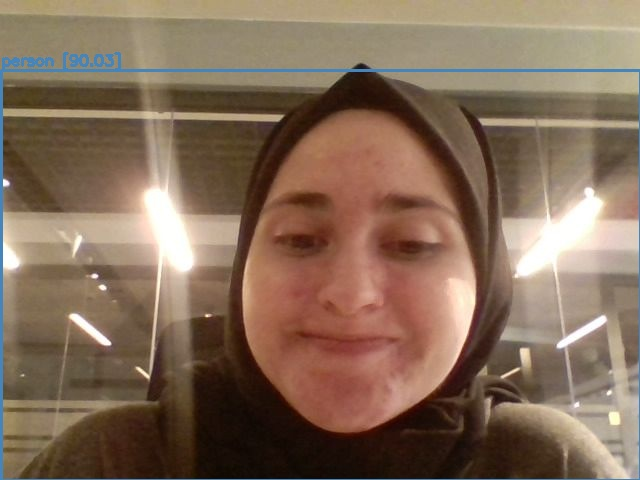

In [36]:
try:
  filename = take_photo('person.jpg')
  print('Saved to {}'.format(filename))
  
  # Az önce çekilen resmi gösterin.
  display(Image(filename))
except Exception as err:
  # Kullanıcının web kamerası yoksa veya o yoksa hatalar atılacaktır.
  # sayfaya erişmesi için izin verin.
  print(str(err))

## Web Kamerası Videolarında YOLOv4
YOLOv4'ü web kamerası videosunda çalıştırmak, görüntülerden biraz daha karmaşıktır. Web kameramızı girdi olarak kullanarak bir video akışı başlatmamız gerekiyor. Ardından, her kareyi YOLOv4 modelimiz aracılığıyla çalıştırırız ve sınırlayıcı algılama(lar) kutusunu içeren bir bindirme görüntüsü oluştururuz. Ardından, sınırlayıcı kutu görüntüsünü video akışımızın bir sonraki karesine geri yerleştiririz.

YOLOv4, algılamaları gerçek zamanlı olarak çalıştırabilecek kadar hızlıdır!

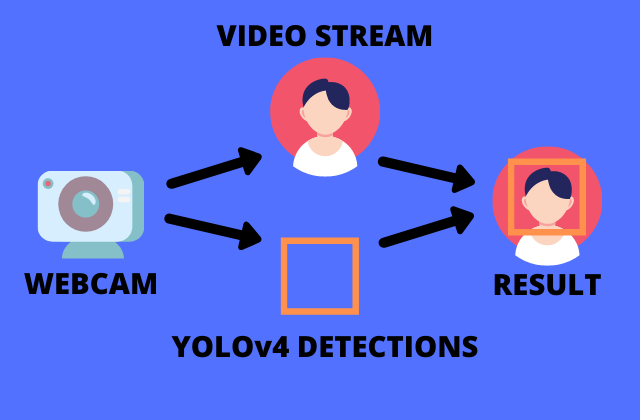

Aşağıda, görüntüler için kullanılana benzer JavaScript kullanarak video akışını başlatmak için bir işlev bulunmaktadır. Video akışı çerçeveleri, YOLOv4'e girdi olarak beslenir.

In [31]:
# Web kameramızı girdi olarak kullanarak canlı video akışımızı düzgün bir şekilde oluşturmak için JavaScript kullanımı
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bitirdiğinizde, bu projeyi durdurmak için buraya veya videoya tıklayın</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [19]:
# web kamerasından video akışını başlat
video_stream()
# video etiketi
label_html = 'Capturing...'
# sınırlayıcı kutuyu boşaltmak için başlat
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # JS yanıtını OpenCV Görüntüsüne dönüştür
    frame = js_to_image(js_reply["img"])

    # sınırlayıcı kutu için şeffaf kaplama oluştur
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # video karesinde darknet yardımcımızı arayın
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # Algılamalar arasında dolaşın ve bunları şeffaf bindirme görüntüsüne çizin
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bbox bindirmesini baytlara dönüştür
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bbox'ı güncelleyin, böylece sonraki kare yeni bindirme alır
    bbox = bbox_bytes

<IPython.core.display.Javascript object>